In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script><script type="text/javascript">if (window.MathJax) {MathJax.Hub.Config({SVG: {font: "STIX-Web"}});}</script><script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window._Plotly) {require(['plotly'],function(plotly) {window._Plotly=plotly;});}</script>

In [11]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [12]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [13]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


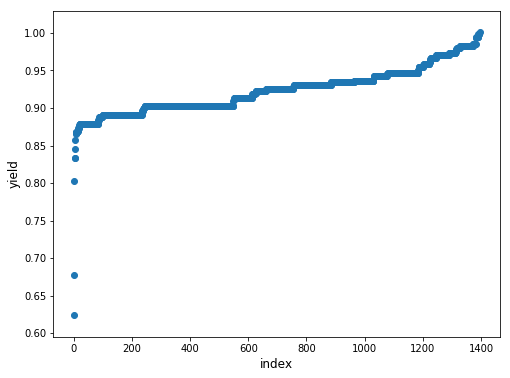

In [14]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

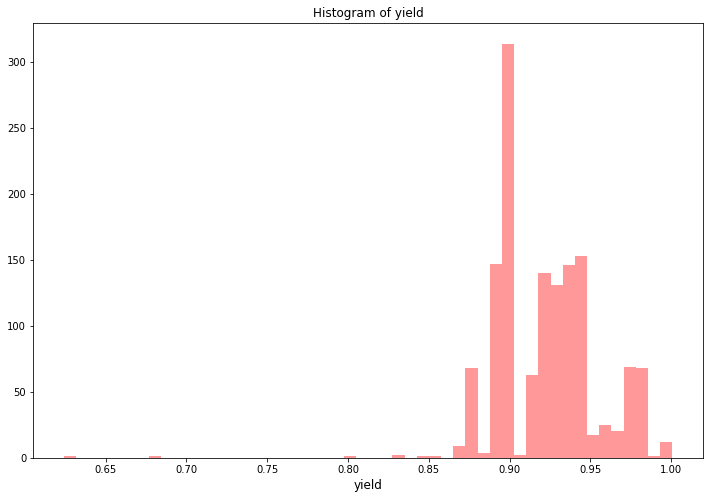

In [15]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [16]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [17]:
# 删除缺失率超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]##如果为true返回的是比率，na总会排在第一位
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [18]:
train[col].value_counts(normalize=True, dropna=False).values

array([0.22085445, 0.09268646, 0.08327299, 0.07603186, 0.06661839,
       0.05792904, 0.04779146, 0.04634323, 0.044895  , 0.03258508,
       0.03258508, 0.03041274, 0.02389573, 0.01593049, 0.01375815,
       0.01375815, 0.01230992, 0.01086169, 0.00796524, 0.00724113,
       0.0057929 , 0.00506879, 0.00506879, 0.00289645, 0.00289645,
       0.00289645, 0.00217234, 0.00217234, 0.00217234, 0.00217234,
       0.00217234, 0.00144823, 0.00144823, 0.00144823, 0.00144823,
       0.00072411, 0.00072411, 0.00072411, 0.00072411, 0.00072411,
       0.00072411, 0.00072411, 0.00072411, 0.00072411, 0.00072411,
       0.00072411, 0.00072411, 0.00072411, 0.00072411, 0.00072411,
       0.00072411, 0.00072411, 0.00072411, 0.00072411, 0.00072411,
       0.00072411, 0.00072411, 0.00072411, 0.00072411, 0.00072411,
       0.00072411, 0.00072411, 0.00072411, 0.00072411])

In [19]:
# 合并数据集
target = train['收率']
print(train.columns)
print(test.columns)
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
#data = data.fillna(-1)
data[0:10]

Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', '收率'],
      dtype='object')
Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14'],
      dtype='object')


,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14
0,sample_1528,13:30:00,38.0,NaN,NaN,15:30:00,100,16:30:00,102.0,17:30:00,103.0,18:30:00,104.0,300,21:00-21:30,50.0,9.0,22:00:00,75,22:30:00,70.0,6:30-7:00,350.0,7:00-8:00,8:00:00,65,11:30:00,45.0,11:30-13:00,14:00-15:30,NaN,800.0,400
1,sample_1698,14:00:00,29.0,NaN,NaN,16:00:00,101,17:00:00,103.0,18:00:00,104.0,19:00:00,105.0,200,19:00-20:00,50.0,9.0,20:00:00,80,21:00:00,73.0,21:00-22:00,320.0,22:00-23:00,23:00:00,80,6:00:00,45.0,6:00-7:30,7:30-9:00,9:00-10:00,1200.0,400
2,sample_639,14:00:00,29.0,NaN,NaN,16:00:00,102,17:00:00,103.0,18:00:00,104.0,19:00:00,105.0,200,19:00-19:30,50.0,9.0,20:00:00,79,21:00:00,73.0,21:00-22:00,320.0,22:00-23:00,23:00:00,80,1:00:00,45.0,1:00-2:30,2:30-4:00,4:00-5:00,1200.0,400
3,sample_483,1:30:00,38.0,NaN,NaN,3:00:00,100,4:00:00,102.0,5:00:00,103.0,6:00:00,104.0,200,6:30-7:00,50.0,10.0,7:30:00,70,8:00:00,78.0,13:30-14:30,290.0,14:30-15:30,15:30:00,65,18:00:00,45.0,19:00-20:30,21:30-23:00,NaN,800.0,400
4,sample_617,22:00:00,29.0,NaN,NaN,0:00:00,101,1:00:00,103.0,2:00:00,104.0,3:00:00,105.0,200,3:00-4:00,50.0,9.0,4:00:00,80,5:00:00,73.0,5:00-6:00,320.0,6:00-7:00,7:00:00,80,9:00:00,45.0,9:00-10:30,10:30-12:00,12:00-13:00,1200.0,420
5,sample_373,2:00:00,39.0,2:30:00,80.0,3:30:00,100,4:30:00,103.0,5:30:00,104.0,6:30:00,102.0,300,11:30-12:00,50.0,9.0,12:00:00,70,12:30:00,75.0,17:30-18:00,NaN,18:00-20:00,20:00:00,65,3:00:00,45.0,3:00-4:30,5:30-7:00,NaN,800.0,420
6,sample_577,8:00:00,29.0,NaN,NaN,10:00:00,101,11:00:00,103.0,12:00:00,104.0,13:00:00,105.0,200,13:00-14:00,50.0,9.0,14:00:00,80,15:00:00,73.0,15:00-16:00,320.0,16:00-17:00,17:00:00,80,19:00:00,45.0,19:00-20:30,20:30-22:00,22:00-23:00,1200.0,400
7,sample_212,6:00:00,29.0,NaN,NaN,8:00:00,101,9:00:00,102.0,10:00:00,103.0,11:00:00,103.0,200,11:00-12:00,50.0,9.0,12:00:00,78,13:00:00,73.0,13:00-14:00,320.0,14:00-15:00,15:00:00,80,17:00:00,45.0,17:00-18:30,18:30-20:00,20:00-21:00,1200.0,400
8,sample_521,17:30:00,21.0,NaN,NaN,19:00:00,100,20:00:00,101.0,21:00:00,102.0,22:00:00,105.0,300,22:30-23:00,50.0,9.0,23:30:00,70,0:00:00,78.0,2:00-3:00,340.0,3:00-4:30,4:30:00,65,6:30:00,45.0,6:30-8:00,8:30-10:00,NaN,800.0,420
9,sample_1026,11:00:00,21.0,NaN,NaN,12:30:00,100,13:30:00,102.0,14:30:00,103.0,15:30:00,105.0,200,16:00-16:30,50.0,9.0,17:00:00,70,17:30:00,78.0,22:00-23:00,280.0,23:00-0:00,0:00:00,64,2:00:00,50.0,6:00-7:30,8:00-9:30,NaN,800.0,400


In [20]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

UnboundLocalError: ("local variable 'tm' referenced before assignment", 'occurred at index 1491')

In [25]:
cate_columns = [f for f in data.columns if f != '样本id']
data[0:10]

,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14
0,sample_1528,0,38.0,-1,-1.0,0,100,0,102.0,0,103.0,0,104.0,300,0.5,50.0,9.0,0,75,0,70.0,0.5,350.0,1.0,0,65,0,45.0,1.5,1.5,-1.0,800.0,400
1,sample_1698,0,29.0,-1,-1.0,0,101,0,103.0,0,104.0,0,105.0,200,1.0,50.0,9.0,0,80,0,73.0,1.0,320.0,1.0,0,80,0,45.0,1.5,1.5,1.0,1200.0,400
2,sample_639,0,29.0,-1,-1.0,0,102,0,103.0,0,104.0,0,105.0,200,0.5,50.0,9.0,0,79,0,73.0,1.0,320.0,1.0,0,80,0,45.0,1.5,1.5,1.0,1200.0,400
3,sample_483,0,38.0,-1,-1.0,0,100,0,102.0,0,103.0,0,104.0,200,0.5,50.0,10.0,0,70,0,78.0,1.0,290.0,1.0,0,65,0,45.0,1.5,1.5,-1.0,800.0,400
4,sample_617,0,29.0,-1,-1.0,0,101,0,103.0,0,104.0,0,105.0,200,1.0,50.0,9.0,0,80,0,73.0,1.0,320.0,1.0,0,80,0,45.0,1.5,1.5,1.0,1200.0,420
5,sample_373,0,39.0,0,80.0,0,100,0,103.0,0,104.0,0,102.0,300,0.5,50.0,9.0,0,70,0,75.0,0.5,-1.0,2.0,0,65,0,45.0,1.5,1.5,-1.0,800.0,420
6,sample_577,0,29.0,-1,-1.0,0,101,0,103.0,0,104.0,0,105.0,200,1.0,50.0,9.0,0,80,0,73.0,1.0,320.0,1.0,0,80,0,45.0,1.5,1.5,1.0,1200.0,400
7,sample_212,0,29.0,-1,-1.0,0,101,0,102.0,0,103.0,0,103.0,200,1.0,50.0,9.0,0,78,0,73.0,1.0,320.0,1.0,0,80,0,45.0,1.5,1.5,1.0,1200.0,400
8,sample_521,0,21.0,-1,-1.0,0,100,0,101.0,0,102.0,0,105.0,300,0.5,50.0,9.0,0,70,0,78.0,1.0,340.0,1.5,0,65,0,45.0,1.5,1.5,-1.0,800.0,420
9,sample_1026,0,21.0,-1,-1.0,0,100,0,102.0,0,103.0,0,105.0,200,0.5,50.0,9.0,0,70,0,78.0,1.0,280.0,1.0,0,64,0,50.0,1.5,1.5,-1.0,800.0,400


In [27]:
#label encoder
#for f in cate_columns:
#    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))##利用map实现dict的映射关系，unique返回的是不重复的值
#train = data[:train.shape[0]]
#test  = data[train.shape[0]:]
#train[0:10]

,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,sample_1698,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,1,1,0
2,sample_639,0,1,0,0,0,2,0,1,0,1,0,1,1,0,0,0,0,2,0,1,1,1,0,0,1,0,0,0,0,1,1,0
3,sample_483,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3,0,2,1,2,0,0,0,0,0,0,0,0,0,0
4,sample_617,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,1,1,1
5,sample_373,0,2,1,1,0,0,0,1,0,1,0,2,0,0,0,0,0,3,0,3,0,3,1,0,0,0,0,0,0,0,0,1
6,sample_577,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,1,1,0
7,sample_212,0,1,0,0,0,1,0,0,0,0,0,3,1,1,0,0,0,4,0,1,1,1,0,0,1,0,0,0,0,1,1,0
8,sample_521,0,3,0,0,0,0,0,2,0,2,0,1,0,0,0,0,0,3,0,2,1,4,2,0,0,0,0,0,0,0,0,1
9,sample_1026,0,3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,3,0,2,1,5,0,0,2,0,1,0,0,0,0,0


In [21]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_features = []

for f1 in cate_columns:
    rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if rate < 0.50:
        for f2 in li:
            col_name = f1+"_"+f2+'_mean'
            mean_features.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            for df in [train, test]:
                df[col_name] = df[f].map(order_label)

train.drop(li, axis=1, inplace=True)

NameError: name 'cate_columns' is not defined

In [32]:
train.drop(['样本id','target'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values
print(X_train.shape)
print(X_test.shape)

(1381, 67)
(150, 67)


In [33]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1


Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000246128	valid_1's l2: 0.0002648
[400]	training's l2: 0.000195305	valid_1's l2: 0.00021725


[600]	training's l2: 0.000179492	valid_1's l2: 0.000209563
[800]	training's l2: 0.00017249	valid_1's l2: 0.000207023
[1000]	training's l2: 0.000168295	valid_1's l2: 0.000205705


[1200]	training's l2: 0.000165147	valid_1's l2: 0.000204514
[1400]	training's l2: 0.000162681	valid_1's l2: 0.00020399
[1600]	training's l2: 0.000160767	valid_1's l2: 0.000203487
[1800]	training's l2: 0.000159219	valid_1's l2: 0.000203041


[2000]	training's l2: 0.000157744	valid_1's l2: 0.00020275
Early stopping, best iteration is:
[2073]	training's l2: 0.00015723	valid_1's l2: 0.000202496


fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000237718	valid_1's l2: 0.000258432
[400]	training's l2: 0.000191959	valid_1's l2: 0.000234496


[600]	training's l2: 0.000177594	valid_1's l2: 0.000228385
[800]	training's l2: 0.000170434	valid_1's l2: 0.000225971


[1000]	training's l2: 0.000165987	valid_1's l2: 0.000225499
[1200]	training's l2: 0.000162753	valid_1's l2: 0.00022513
Early stopping, best iteration is:
[1181]	training's l2: 0.000163032	valid_1's l2: 0.000225029


fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000251575	valid_1's l2: 0.000315771
[400]	training's l2: 0.000202832	valid_1's l2: 0.000254298


[600]	training's l2: 0.000184443	valid_1's l2: 0.00023588


[800]	training's l2: 0.00017549	valid_1's l2: 0.000228004
[1000]	training's l2: 0.000170374	valid_1's l2: 0.000224062
[1200]	training's l2: 0.000166784	valid_1's l2: 0.000221867


[1400]	training's l2: 0.00016405	valid_1's l2: 0.000220576
[1600]	training's l2: 0.000161874	valid_1's l2: 0.000219571
[1800]	training's l2: 0.000160056	valid_1's l2: 0.00021915


[2000]	training's l2: 0.000158533	valid_1's l2: 0.000218859
[2200]	training's l2: 0.00015714	valid_1's l2: 0.000218571
Early stopping, best iteration is:
[2149]	training's l2: 0.000157428	valid_1's l2: 0.000218509


fold n°4
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000250266	valid_1's l2: 0.000271248
[400]	training's l2: 0.000198246	valid_1's l2: 0.000233212


[600]	training's l2: 0.000183068	valid_1's l2: 0.000220366
[800]	training's l2: 0.000176268	valid_1's l2: 0.000215252
[1000]	training's l2: 0.00017198	valid_1's l2: 0.000212795


[1200]	training's l2: 0.000168889	valid_1's l2: 0.000210707


[1400]	training's l2: 0.000166329	valid_1's l2: 0.000208815
[1600]	training's l2: 0.00016432	valid_1's l2: 0.000207633
[1800]	training's l2: 0.000162641	valid_1's l2: 0.000206553


[2000]	training's l2: 0.000161038	valid_1's l2: 0.000205824
[2200]	training's l2: 0.000159698	valid_1's l2: 0.000205131


Early stopping, best iteration is:
[2258]	training's l2: 0.000159309	valid_1's l2: 0.000204843


fold n°5
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000255988	valid_1's l2: 0.000241045


[400]	training's l2: 0.000204118	valid_1's l2: 0.000188941
[600]	training's l2: 0.000187881	valid_1's l2: 0.000176505


[800]	training's l2: 0.000180274	valid_1's l2: 0.000172733
[1000]	training's l2: 0.000175739	valid_1's l2: 0.000171179


[1200]	training's l2: 0.000172231	valid_1's l2: 0.000170281
[1400]	training's l2: 0.000169552	valid_1's l2: 0.000169714
[1600]	training's l2: 0.000167255	valid_1's l2: 0.000169109


[1800]	training's l2: 0.000165554	valid_1's l2: 0.00016878
[2000]	training's l2: 0.000164032	valid_1's l2: 0.000168626
Early stopping, best iteration is:
[2030]	training's l2: 0.000163798	valid_1's l2: 0.000168512


CV score: 0.00020388


In [34]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423818


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257018	valid_data-rmse:0.257706


[200]	train-rmse:0.156663	valid_data-rmse:0.15729


[300]	train-rmse:0.096075	valid_data-rmse:0.096806


[400]	train-rmse:0.059641	valid_data-rmse:0.060476


[500]	train-rmse:0.037948	valid_data-rmse:0.038956


[600]	train-rmse:0.025291	valid_data-rmse:0.026604


[700]	train-rmse:0.018098	valid_data-rmse:0.019901


[800]	train-rmse:0.01413	valid_data-rmse:0.016506


[900]	train-rmse:0.012002	valid_data-rmse:0.014903


[1000]	train-rmse:0.010874	valid_data-rmse:0.014158


[1100]	train-rmse:0.010214	valid_data-rmse:0.013845


[1200]	train-rmse:0.009772	valid_data-rmse:0.013725


[1300]	train-rmse:0.009465	valid_data-rmse:0.013688


[1400]	train-rmse:0.009219	valid_data-rmse:0.013693


[1500]	train-rmse:0.009018	valid_data-rmse:0.013715


Stopping. Best iteration:
[1374]	train-rmse:0.009278	valid_data-rmse:0.013682



fold n°2
[0]	train-rmse:0.424042	valid_data-rmse:0.41936


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257695	valid_data-rmse:0.254098


[200]	train-rmse:0.157078	valid_data-rmse:0.154216


[300]	train-rmse:0.096318	valid_data-rmse:0.093924


[400]	train-rmse:0.059766	valid_data-rmse:0.057887


[500]	train-rmse:0.03797	valid_data-rmse:0.036677


[600]	train-rmse:0.025215	valid_data-rmse:0.02487


[700]	train-rmse:0.017958	valid_data-rmse:0.019006


[800]	train-rmse:0.01393	valid_data-rmse:0.016403


[900]	train-rmse:0.011737	valid_data-rmse:0.015374


[1000]	train-rmse:0.010573	valid_data-rmse:0.015045


[1100]	train-rmse:0.009891	valid_data-rmse:0.014959


[1200]	train-rmse:0.009431	valid_data-rmse:0.014985


[1300]	train-rmse:0.009095	valid_data-rmse:0.015046


Stopping. Best iteration:
[1106]	train-rmse:0.009858	valid_data-rmse:0.014957



fold n°3
[0]	train-rmse:0.422401	valid_data-rmse:0.425951


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256656	valid_data-rmse:0.259876


[200]	train-rmse:0.156403	valid_data-rmse:0.159403


[300]	train-rmse:0.09587	valid_data-rmse:0.09871


[400]	train-rmse:0.05951	valid_data-rmse:0.061864


[500]	train-rmse:0.037909	valid_data-rmse:0.039926


[600]	train-rmse:0.025298	valid_data-rmse:0.027268


[700]	train-rmse:0.01815	valid_data-rmse:0.020467


[800]	train-rmse:0.014207	valid_data-rmse:0.017132


[900]	train-rmse:0.012093	valid_data-rmse:0.015647


[1000]	train-rmse:0.010918	valid_data-rmse:0.015087


[1100]	train-rmse:0.010232	valid_data-rmse:0.01492


[1200]	train-rmse:0.009793	valid_data-rmse:0.014892


[1300]	train-rmse:0.009472	valid_data-rmse:0.01492


[1400]	train-rmse:0.009233	valid_data-rmse:0.014986


Stopping. Best iteration:
[1209]	train-rmse:0.009763	valid_data-rmse:0.014888



fold n°4
[0]	train-rmse:0.422949	valid_data-rmse:0.423759


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257007	valid_data-rmse:0.257027


[200]	train-rmse:0.156633	valid_data-rmse:0.15617


[300]	train-rmse:0.096037	valid_data-rmse:0.095534


[400]	train-rmse:0.059612	valid_data-rmse:0.059315


[500]	train-rmse:0.037921	valid_data-rmse:0.037944


[600]	train-rmse:0.0253	valid_data-rmse:0.025747


[700]	train-rmse:0.018189	valid_data-rmse:0.019193


[800]	train-rmse:0.014313	valid_data-rmse:0.015943


[900]	train-rmse:0.012217	valid_data-rmse:0.01445


[1000]	train-rmse:0.011048	valid_data-rmse:0.013762


[1100]	train-rmse:0.010347	valid_data-rmse:0.013454


[1200]	train-rmse:0.009888	valid_data-rmse:0.013316


[1300]	train-rmse:0.009534	valid_data-rmse:0.013247


[1400]	train-rmse:0.009259	valid_data-rmse:0.013224


[1500]	train-rmse:0.009038	valid_data-rmse:0.013215


[1600]	train-rmse:0.008857	valid_data-rmse:0.013233


Stopping. Best iteration:
[1492]	train-rmse:0.009055	valid_data-rmse:0.013211



fold n°5
[0]	train-rmse:0.423228	valid_data-rmse:0.422634


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257199	valid_data-rmse:0.256842


[200]	train-rmse:0.156778	valid_data-rmse:0.156556


[300]	train-rmse:0.096163	valid_data-rmse:0.095844


[400]	train-rmse:0.059721	valid_data-rmse:0.059385


[500]	train-rmse:0.038047	valid_data-rmse:0.037861


[600]	train-rmse:0.025417	valid_data-rmse:0.02559


[700]	train-rmse:0.018264	valid_data-rmse:0.018969


[800]	train-rmse:0.01434	valid_data-rmse:0.015704


[900]	train-rmse:0.012267	valid_data-rmse:0.01421


[1000]	train-rmse:0.01112	valid_data-rmse:0.013575


[1100]	train-rmse:0.010464	valid_data-rmse:0.01334


[1200]	train-rmse:0.010039	valid_data-rmse:0.013287


[1300]	train-rmse:0.009722	valid_data-rmse:0.013293


[1400]	train-rmse:0.009483	valid_data-rmse:0.013336


Stopping. Best iteration:
[1212]	train-rmse:0.010001	valid_data-rmse:0.013276



CV score: 0.00019667


In [35]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.0001942832622965329

In [39]:
sub_df = pd.read_csv('./jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv('solution.csv')